# Music Snippet Similarity


This notebook uses the output of the ```midiParser.ipynb``` notebook to calculate similarity amongst historical snippets of MIDI data. The similarity metrics used for experiments are **cosine similarity**, **Jaccard similarity**, **euclidian distance**, and **Levenshtein distance**.

We start with the experimental MIDI file of Keith playing *La Dispute - Yann Tiersen* four times in a row (the first two times with a metronome and the last two times without a metronome. 

This notebook seeks to experiment with traditional similarity score mechanisms such as cosine similarity, euclidian distance, and jaccard similarity. Additionally, we experiment with Levenshtein distance, which is referenced in a relevant [paper](https://www.cs.cmu.edu/~gxia/PDF/cmmr2013_submission_32.pdf). 

---

In [155]:
# global hyperparameters

# defines the min and max note length to use when looking for similarity
# (i.e. if minNotes = 5 and maxNotes = 20, search only historical snippets between 5 and 20 notes in length for similarity)
minNotes = 5
maxNotes = 5

minMeasures = 1
maxMeasures = 1

midiPath = 'converted.mid'

In [156]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import gensim, logging
import pprint
import os

import warnings
warnings.filterwarnings("ignore")

from music21 import converter, corpus, instrument, midi, note, chord, pitch, roman, stream
import mido
from mido import Message, MidiFile, MidiTrack
from sklearn.metrics import jaccard_score

from miditok import REMI, get_midi_programs
from miditoolkit import MidiFile

In [157]:

# read in midi file
wholeMid = mido.MidiFile(midiPath, clip=True)

mf = midi.MidiFile()
mf.open(midiPath)
mf.read()
mf.close()
base_midi = midi.translate.midiFileToStream(mf)

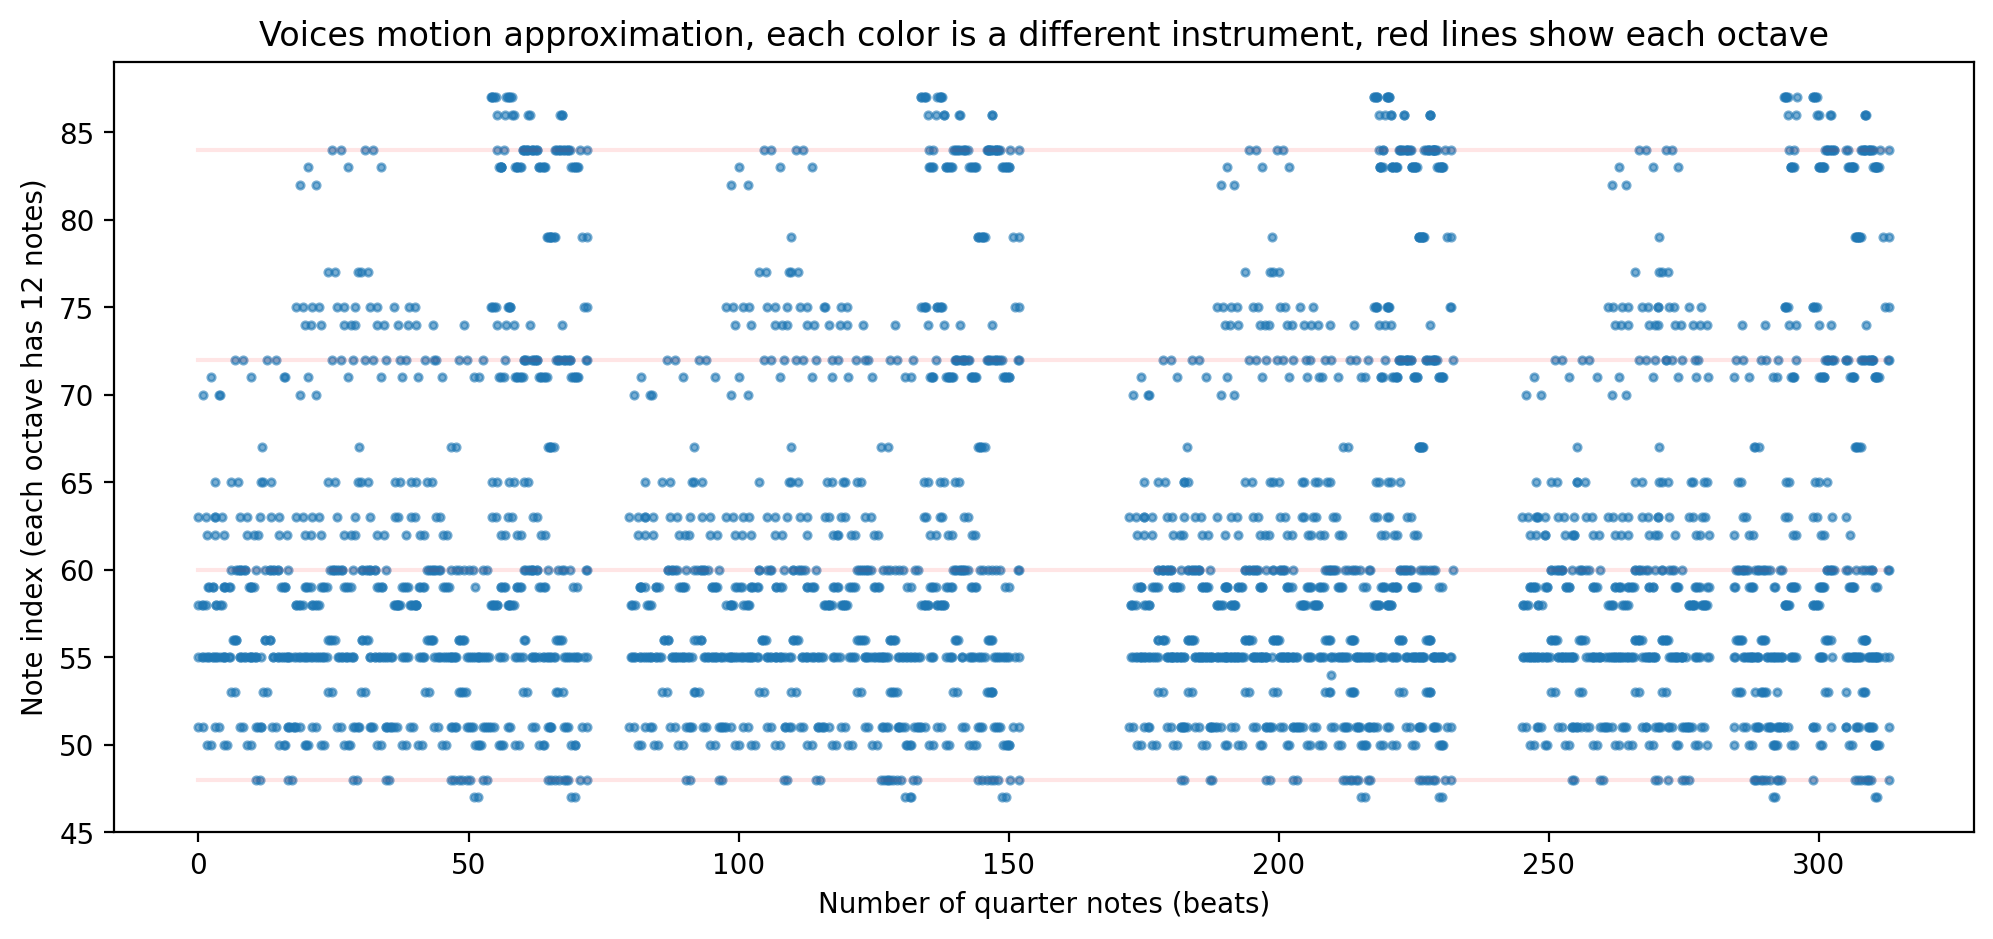

In [158]:
def extract_notes(midi_part):
    parent_element = []
    ret = []
    for nt in midi_part.flat.notes:        
        if isinstance(nt, note.Note):
            ret.append(max(0.0, nt.pitch.ps))
            parent_element.append(nt)
        elif isinstance(nt, chord.Chord):
            for pitch in nt.pitches:
                ret.append(max(0.0, pitch.ps))
                parent_element.append(nt)
    
    return ret, parent_element

def print_parts_countour(midi):
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(1, 1, 1)
    minPitch = pitch.Pitch('C10').ps
    maxPitch = 0
    xMax = 0
    
    # Drawing notes.
    for i in range(len(midi.parts)):
        top = midi.parts[i].flat.notes                  
        y, parent_element = extract_notes(top)
        if (len(y) < 1): continue
            
        x = [n.offset for n in parent_element]
        ax.scatter(x, y, alpha=0.6, s=7)
        
        aux = min(y)
        if (aux < minPitch): minPitch = aux
            
        aux = max(y)
        if (aux > maxPitch): maxPitch = aux
            
        aux = max(x)
        if (aux > xMax): xMax = aux
    
    for i in range(1, 10):
        linePitch = pitch.Pitch('C{0}'.format(i)).ps
        if (linePitch > minPitch and linePitch < maxPitch):
            ax.add_line(mlines.Line2D([0, xMax], [linePitch, linePitch], color='red', alpha=0.1))            

    plt.ylabel("Note index (each octave has 12 notes)")
    plt.xlabel("Number of quarter notes (beats)")
    plt.title('Voices motion approximation, each color is a different instrument, red lines show each octave')
    plt.show()

# Focusing only on 6 first measures to make it easier to understand.
print_parts_countour(base_midi)

Here we can visually see the four different playthroughs within the MIDI file. They look very similar to the most part, but within each playthrough there are some slight differences in timing and duration of each note, since they are played by hand, sometimes with or without a metronome.

<music21.graph.plot.HistogramPitchClass for <music21.stream.Score 0x7fcf44e05a20>>

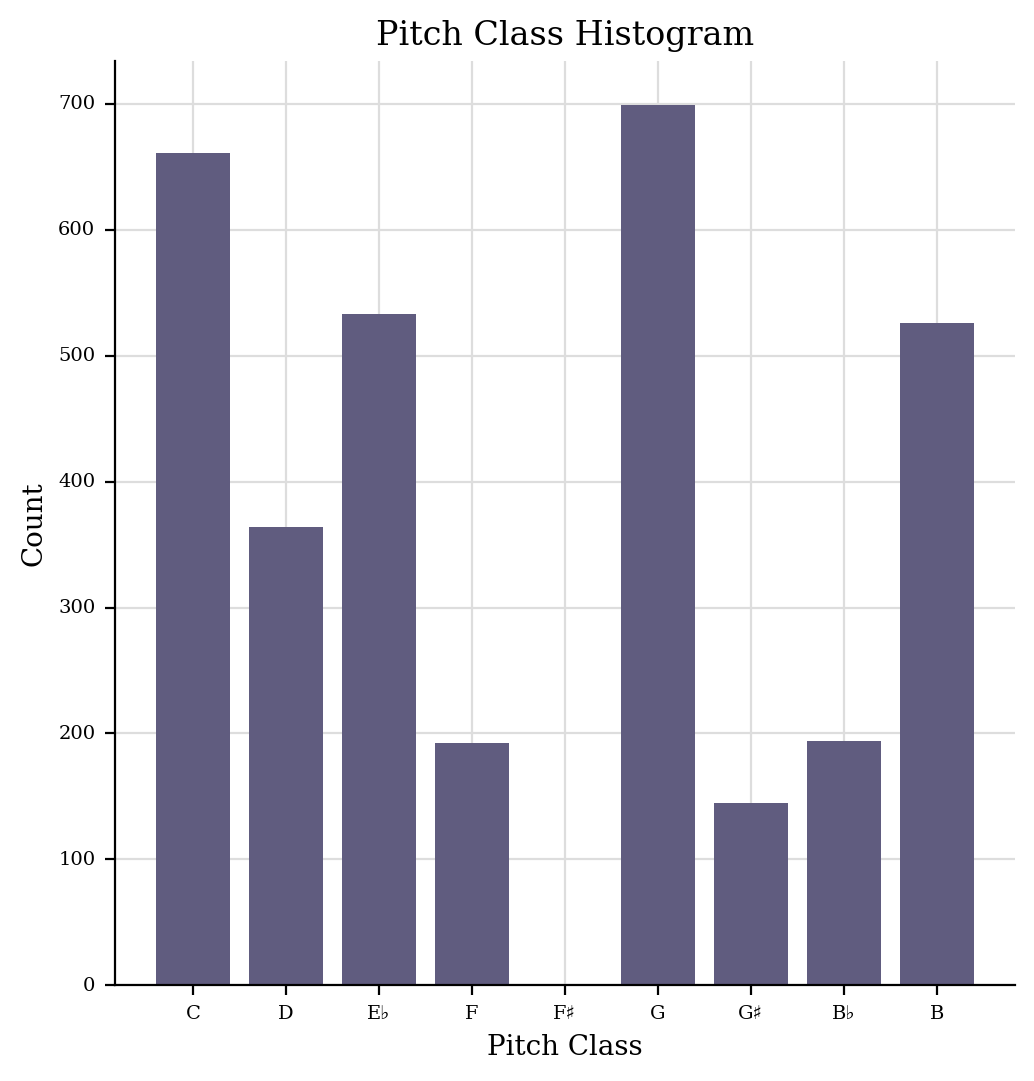

In [159]:
base_midi.plot('histogram', 'pitchClass', 'count')

In [160]:
timeSignature = base_midi.getTimeSignatures()[0]
music_analysis = base_midi.analyze('key')
print("Music time signature: {0}/{1}".format(timeSignature.beatCount, timeSignature.denominator))
print("Expected music key: {0}".format(music_analysis))
print("Music key confidence: {0}".format(music_analysis.correlationCoefficient))
print("Other music key alternatives:")
for analysis in music_analysis.alternateInterpretations:
    if (analysis.correlationCoefficient > 0.5):
        print(analysis)

Music time signature: 4/4
Expected music key: c minor
Music key confidence: 0.8152954046296494
Other music key alternatives:


From these results, we are fairly confident (81%) that the key is C minor and the time signature is 4/4.

## Harmonic Reduction & Analysis

We can do some preprocessing to the raw MIDI file before computing similarity across snippets. Importantly, we can remove unneccessary chords in the piece when analysing similarity through harmonic reduction. This writeup explains why [harmonic analysis](https://myjazzedge.com/harmonic-analysis-step-step-approach/) can be helpful in analysing similarity of music pieces. After harmonic reduction, we get a series of roman numerals used to label chords. This naming system is explained in the following [writeup](https://intmus.github.io/inttheory19-20/06-intro-harmonic/a1-romnum.html).

In [161]:
def note_count(measure, count_dict):
    bass_note = None
    for chord in measure.recurse().getElementsByClass('Chord'):
        # All notes have the same length of its chord parent.
        note_length = chord.quarterLength
        for note in chord.pitches:          
            # If note is "C5", note.name is "C". We use "C5"
            # style to be able to detect more precise inversions.
            note_name = str(note) 
            if (bass_note is None or bass_note.ps > note.ps):
                bass_note = note
                
            if note_name in count_dict:
                count_dict[note_name] += note_length
            else:
                count_dict[note_name] = note_length
        
    return bass_note

In [162]:
def simplify_roman_name(roman_numeral):
    # Chords can get nasty names as "bII#86#6#5",
    # in this method we try to simplify names, even if it ends in
    # a different chord to reduce the chord vocabulary and display
    # chord function clearer.
    ret = roman_numeral.romanNumeral
    inversion_name = None
    inversion = roman_numeral.inversion()
    
    # Checking valid inversions.
    if ((roman_numeral.isTriad() and inversion < 3) or
            (inversion < 4 and
                 (roman_numeral.seventh is not None or roman_numeral.isSeventh()))):
        inversion_name = roman_numeral.inversionName()
        
    if (inversion_name is not None):
        ret = ret + str(inversion_name)
        
    elif (roman_numeral.isDominantSeventh()): ret = ret + "M7"
    elif (roman_numeral.isDiminishedSeventh()): ret = ret + "o7"
    return ret

In [163]:
def harmonic_reduction(midi_file):
    ret = []
    temp_midi = stream.Score()
    temp_midi_chords = midi_file.chordify()
    temp_midi.insert(0, temp_midi_chords)    
    music_key = temp_midi.analyze('key')
    max_notes_per_chord = 4   
    for m in temp_midi_chords.measures(0, None): # None = get all measures.
        if (type(m) != stream.Measure):
            continue
        
        # Here we count all notes length in each measure,
        # get the most frequent ones and try to create a chord with them.
        count_dict = dict()
        bass_note = note_count(m, count_dict)
        if (len(count_dict) < 1):
            ret.append("-") # Empty measure
            continue
        
        sorted_items = sorted(count_dict.items(), key=lambda x:x[1])
        sorted_notes = [item[0] for item in sorted_items[-max_notes_per_chord:]]
        measure_chord = chord.Chord(sorted_notes)
        
        # Convert the chord to the functional roman representation
        # to make its information independent of the music key.
        roman_numeral = roman.romanNumeralFromChord(measure_chord, music_key)
        ret.append(simplify_roman_name(roman_numeral))
        
    return ret

In [164]:
# harmonic reduction for first 10 measures in midi file
harmonic_reduction(base_midi)[0:10]

['III53', 'V42', 'i7', 'i', 'i7', 'v', 'i', 'iv42', 'i7', 'III']

In [165]:
len(harmonic_reduction(base_midi))

77

Since the harmonic sequences are just a list of strings, we could handle it as a common sentence from a text document. We can now use a word tokenizer such as word2vec to tokenize these sequences.

## Tokenization

There are three different approaches to tokenization:
 - Applying word2vec to the processed harmonic reductions
 - Applying miditok to the raw MIDI events
 - Applying word2vec to the processed MIDI notes

### Approach 1: Harmonic Reduction Tokens

In [166]:
# generate dataframe of snippets
snippets = []
reduction = harmonic_reduction(base_midi)
for i in range(len(reduction)):
    snippet = reduction[i:i + maxMeasures]
    if len(snippet) >= minMeasures:
        snippets.append(snippet)
snippets

[['III53'],
 ['V42'],
 ['i7'],
 ['i'],
 ['i7'],
 ['v'],
 ['i'],
 ['iv42'],
 ['i7'],
 ['III'],
 ['#vii'],
 ['III53'],
 ['i7'],
 ['i7'],
 ['VII'],
 ['i'],
 ['i'],
 ['i53'],
 ['i53'],
 ['iii'],
 ['III53'],
 ['III42'],
 ['i7'],
 ['i'],
 ['i7'],
 ['III42'],
 ['i'],
 ['i'],
 ['i7'],
 ['III42'],
 ['i43'],
 ['V64'],
 ['i7'],
 ['i53'],
 ['#vii'],
 ['i'],
 ['i'],
 ['i53'],
 ['i64'],
 ['-'],
 ['-'],
 ['-'],
 ['-'],
 ['III53'],
 ['i43'],
 ['III7'],
 ['i65'],
 ['III53'],
 ['i43'],
 ['iii7'],
 ['i65'],
 ['III'],
 ['i43'],
 ['i6'],
 ['III'],
 ['i'],
 ['i'],
 ['i53'],
 ['III'],
 ['-'],
 ['-'],
 ['III'],
 ['i'],
 ['i'],
 ['i65'],
 ['III'],
 ['iii'],
 ['i53'],
 ['i53'],
 ['i7'],
 ['i'],
 ['i'],
 ['i'],
 ['iv43'],
 ['i'],
 ['i53'],
 ['i53']]

In [167]:
model = gensim.models.Word2Vec(snippets, min_count=2, window=4)

In [168]:
def vectorize_harmony_1(model, harmonic_reduction):
    # Gets the model vector values for each chord from the reduction.
    word_vecs = []
    for word in harmonic_reduction:
        try:
            vec = model.wv[word]
            word_vecs.append(vec)
        except KeyError:
            # Ignore, if the word doesn't exist in the vocabulary
            pass
    
    # Assuming that document vector is the mean of all the word vectors.
    return np.mean(word_vecs, axis=0)

In [169]:
def calculate_similarity_1(targets, model, source, similarityMetric):
    
    source_vec = vectorize_harmony_1(model, source)    
    results = []
    count = 0
    for target in targets:
            
        target_vec = vectorize_harmony_1(model, target)   
        
        if similarityMetric == "cosine":
            sim_score = cosine_similarity(source_vec, target_vec)
        elif similarityMetric == "jaccard":
            sim_score = jaccard(source_vec, target_vec)
        elif similarityMetric == "euclidean":
            sim_score = euclidean(source_vec, target_vec) 
        elif similarityMetric == "levenshtein":
            sim_score = levenshtein(source, target) 
        
        result = [count, sim_score]
        results.append(result)
        count += 1
                
    return results

### Approach 2: MIDI Event Tokenization

In [170]:
# generate snippets
names = []
for i in range(len(wholeMid.tracks[0]) - maxNotes):
    sourceSnippet = mido.MidiFile()
    track = mido.MidiTrack()
    sourceSnippet.tracks.append(track)
    for j in range(maxNotes):
        track.append(wholeMid.tracks[0][i + j])
    fname = "snippets/snippet_"+str(i) + "_" + str(i + maxNotes) + ".mid"
    names.append(fname)
    sourceSnippet.save(fname)

In [171]:
def vectorize_harmony_2(fpath):
    pitch_range = range(0, 127)
    beat_res = {(0, 4): 8, (4, 12): 4}
    nb_velocities = 16
    additional_tokens = {'Chord': True, 'Rest': True, 'Tempo': True, 'Program': False, 'TimeSignature': False,
                     'rest_range': (2, 8),  # (half, 8 beats)
                     'nb_tempos': 32,  # nb of tempo bins
                     'tempo_range': (40, 250)}  # (min, max)
    tokenizer = REMI(pitch_range, beat_res, nb_velocities, mask=True)
    midi = MidiFile(fpath)
    tokens = tokenizer.midi_to_tokens(midi)
    try:
        tokens = np.array(tokens[0])
        return np.mean(tokens, axis=0)
    except IndexError:
        return 0


In [172]:
def calculate_similarity_2(targets, source, similarityMetric):
    
    source_vec = vectorize_harmony_2(source)    
    results = []
    count = 0
    for target in targets:
            
        target_vec = vectorize_harmony_2(target)
        
        if similarityMetric == "cosine":
            sim_score = cosine_similarity(source_vec, target_vec)
        elif similarityMetric == "jaccard":
            sim_score = jaccard(source_vec, target_vec)
        elif similarityMetric == "euclidean":
            sim_score = euclidean(source_vec, target_vec) 
        elif similarityMetric == "levenshtein":
            sim_score = levenshtein(source, target) 
        
        result = [count, sim_score]
        results.append(result)
        count += 1
                
    return results

### Approach 3: MIDI Note Vectors

In [173]:
def extract_notes(file):
    notes = []
    pick = None
    for j in file:
        songs = instrument.partitionByInstrument(j)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))

    return notes

In [174]:
# generate dataframe of snippets
snips = []
midiFile = converter.parse(midiPath)
notes = extract_notes([midiFile])
for i in range(len(notes)):
    snip = notes[i:i + maxNotes]
    if len(snip) >= minNotes:
        snips.append(snip)

In [74]:
len(snips)

1266

In [75]:
noteModel = gensim.models.Word2Vec(snips, min_count=2, window=4)

<AxesSubplot: xlabel='source_timestamp', ylabel='target_timestamp'>

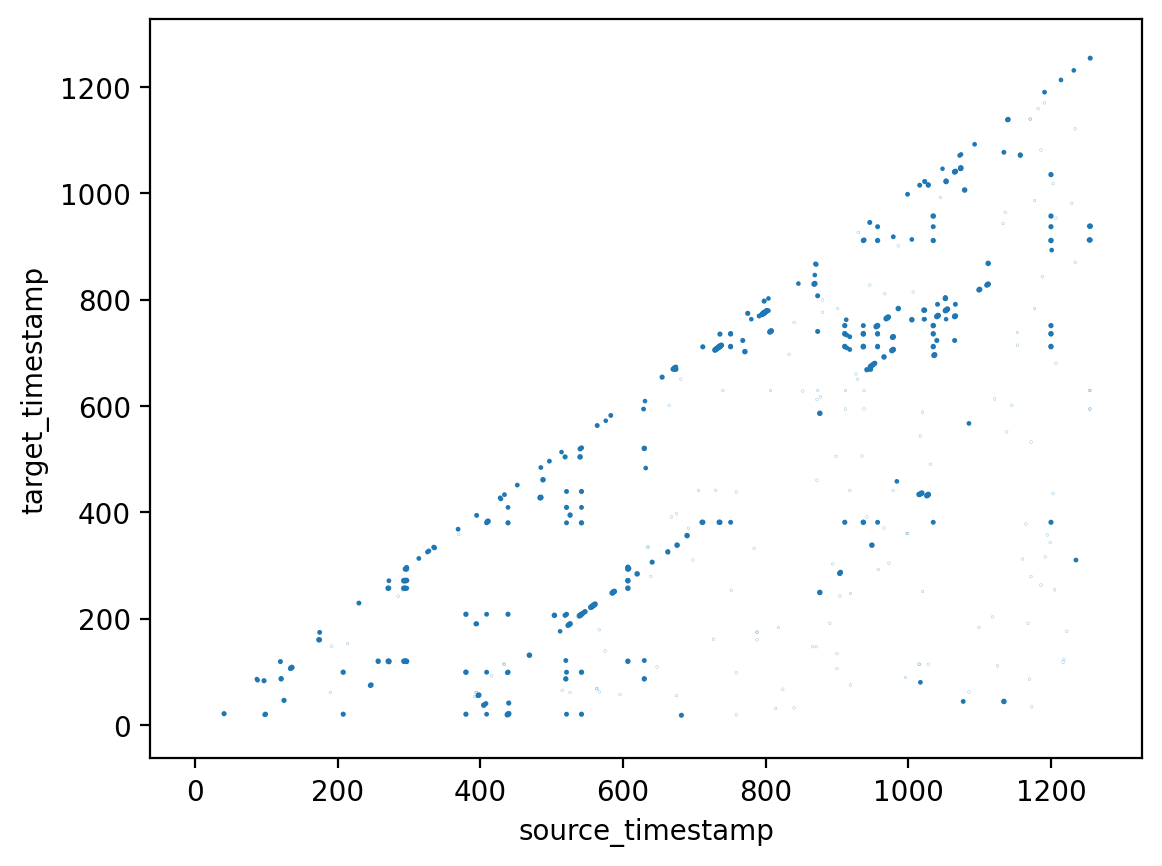

In [76]:
sims = []
for i in range(len(snips)):
    # only calculate on historical timestamps
    source = snips[i]
    targets = snips[0:i]
    sim = calculate_similarity_1(targets, noteModel, source, "jaccard")
    # create a single df
    for match in sim:
       
        # add source measure location
        match.insert(0, i)
        sims.append(match)
simsDF = pd.DataFrame(data=sims, columns=['source_timestamp', 'target_timestamp', 'score'])
simsDF.plot.scatter(x="source_timestamp", y="target_timestamp", s='score')

<AxesSubplot: xlabel='source_timestamp', ylabel='target_timestamp'>

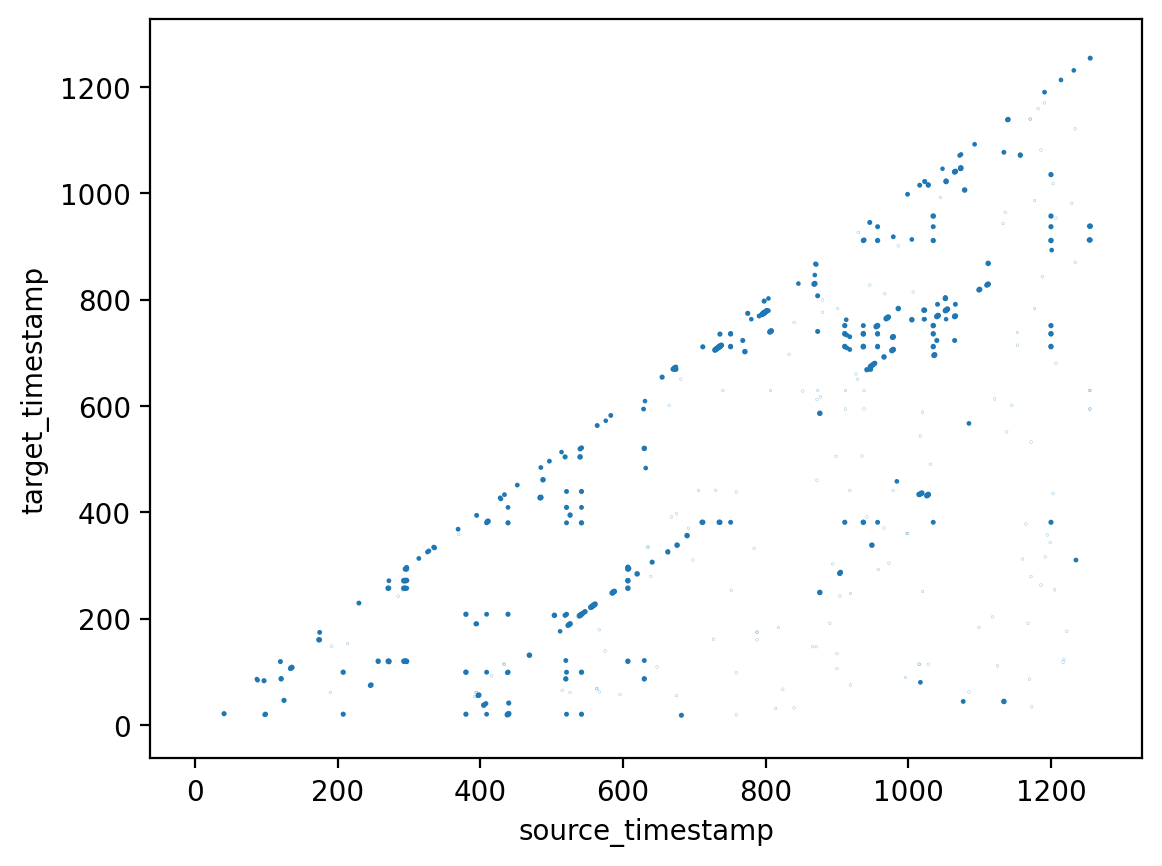

In [176]:
simsDF.plot.scatter(x="source_timestamp", y="target_timestamp", s='score', )

## Similarity Metrics

We also try the following four similarity metrics:
- Cosine Similarity
- Jaccard Similarity
- Euclidean Distance
- Levenshtein Distance


In [177]:
def cosine_similarity(vecA, vecB):
    # Find the similarity between two vectors based on the dot product.
    csim = np.dot(vecA, vecB) / (np.linalg.norm(vecA) * np.linalg.norm(vecB))
    if np.isnan(np.sum(csim)):
        return 0
    
    return csim

In [178]:
def jaccard(vecA, vecB):
    try:
        intersection = len(list(set(vecA).intersection(vecB)))
        union = (len(vecA) + len(vecB)) - intersection
        return float(intersection) / union
    except: 
        return 0

In [179]:
def euclidean(vecA, vecB):
    return np.linalg.norm(vecA - vecB)

In [180]:
def levenshtein(token1, token2):
    distances = np.zeros((len(token1) + 1, len(token2) + 1))

    for t1 in range(len(token1) + 1):
        distances[t1][0] = t1

    for t2 in range(len(token2) + 1):
        distances[0][t2] = t2
        
    a = 0
    b = 0
    c = 0
    
    for t1 in range(1, len(token1) + 1):
        for t2 in range(1, len(token2) + 1):
            if (token1[t1-1] == token2[t2-1]):
                distances[t1][t2] = distances[t1 - 1][t2 - 1]
            else:
                a = distances[t1][t2 - 1]
                b = distances[t1 - 1][t2]
                c = distances[t1 - 1][t2 - 1]
                
                if (a <= b and a <= c):
                    distances[t1][t2] = a + 1
                elif (b <= a and b <= c):
                    distances[t1][t2] = b + 1
                else:
                    distances[t1][t2] = c + 1

    return distances[len(token1)][len(token2)]

## Graphs

Below are the following graphs for the following combinations of hyperparameters

**Tokenization Scheme**:
- Applying word2vec to the processed harmonic reductions
- Applying miditok to the raw MIDI events
- Applying word2vec to the processed MIDI notes

**Similarity Score**:
- Cosine Similarity
- Jaccard Similarity
- Euclidean Distance
- Levenshtein Distance

**Snippet Length**:
- 5 notes
- 10 notes
- 20 notes

There are a total of 3 * 4 * 3 = 36 configurations of hyperparameters tested here.

---

### Approach 1: Harmonic Reduction Tokens

In [181]:
# Snippet note length = 5
minNotes = 1
maxNotes = 5

<AxesSubplot: title={'center': 'Harmonic Reduction Tokenization, Snippet Length=1, Similarity=cosine'}, xlabel='source_timestamp', ylabel='target_timestamp'>

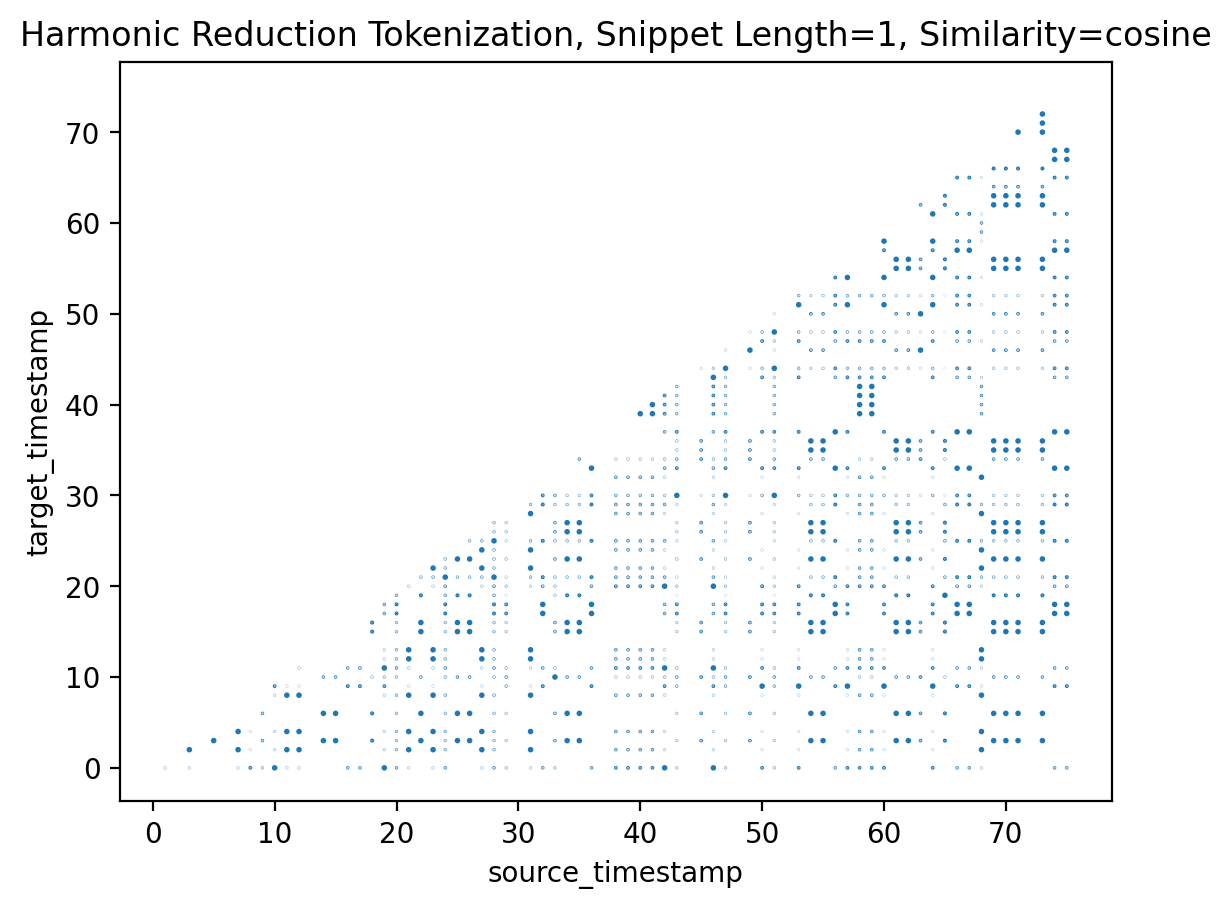

In [182]:
# cosine similarity
similarityMetric = "cosine"

sims = []
for i in range(len(snippets) - maxNotes):
    # only calculate on historical timestamps
    source = snippets[i + maxNotes]
    targets = snippets[0:i]
    sim = calculate_similarity_1(targets, model, source, similarityMetric)
    # create a single df
    for match in sim:
       
        # add source measure location
        match.insert(0, i)
        sims.append(match)
simsDF = pd.DataFrame(data=sims, columns=['source_timestamp', 'target_timestamp', 'score'])
title = "Harmonic Reduction Tokenization, Snippet Length=" + str(minNotes) + ", Similarity=" + similarityMetric
simsDF.plot.scatter(x="source_timestamp", y="target_timestamp", s='score', title=title)

<AxesSubplot: title={'center': 'Harmonic Reduction Tokenization, Snippet Length=1, Similarity=jaccard'}, xlabel='source_timestamp', ylabel='target_timestamp'>

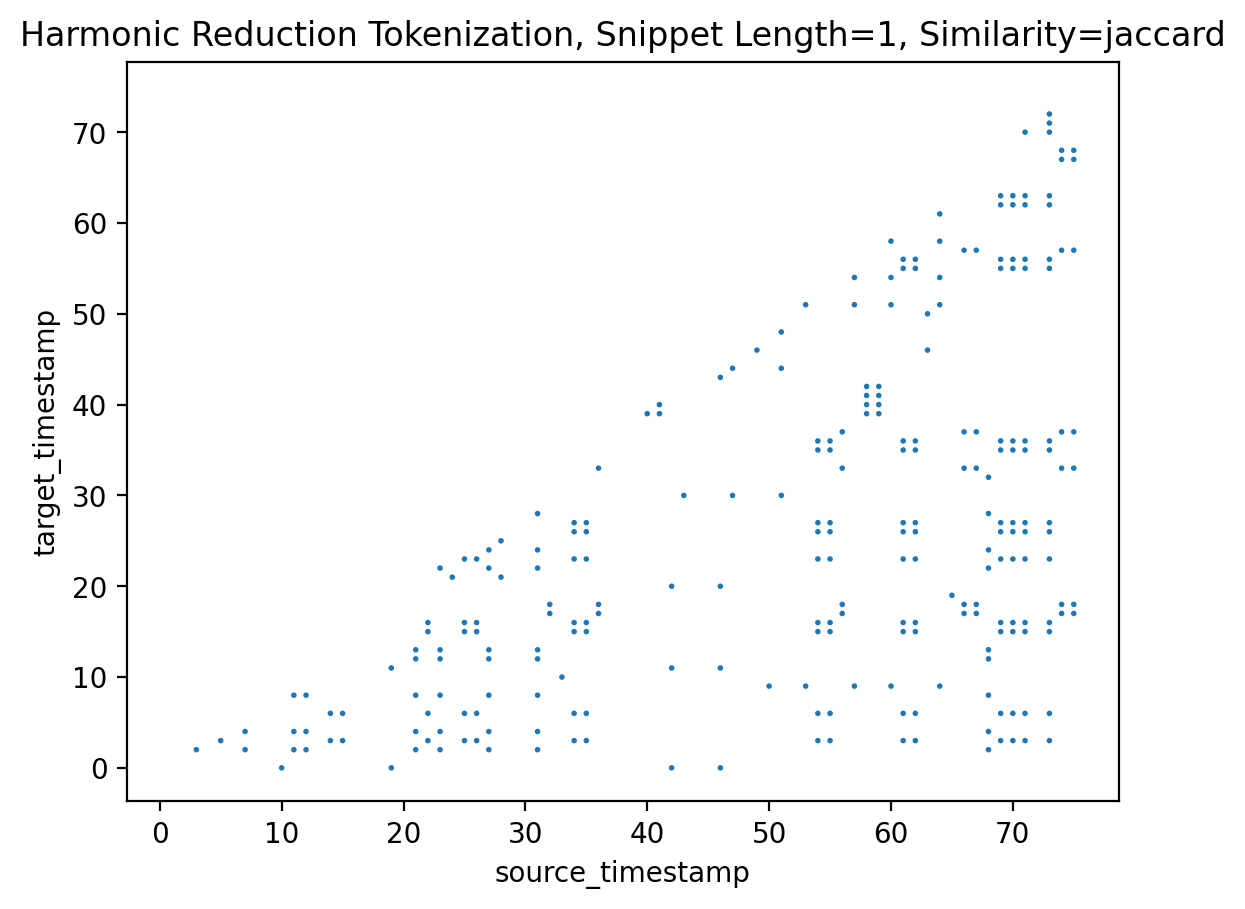

In [183]:
# cosine similarity
similarityMetric = "jaccard"

sims = []
for i in range(len(snippets) - maxNotes):
    # only calculate on historical timestamps
    source = snippets[i+maxNotes]
    targets = snippets[0:i]
    sim = calculate_similarity_1(targets, model, source, similarityMetric)
    # create a single df
    for match in sim:
       
        # add source measure location
        match.insert(0, i)
        sims.append(match)
simsDF = pd.DataFrame(data=sims, columns=['source_timestamp', 'target_timestamp', 'score'])
title = "Harmonic Reduction Tokenization, Snippet Length=" + str(minNotes) + ", Similarity=" + similarityMetric
simsDF.plot.scatter(x="source_timestamp", y="target_timestamp", s='score', title=title)

<AxesSubplot: title={'center': 'Harmonic Reduction Tokenization, Snippet Length=1, Similarity=euclidean'}, xlabel='source_timestamp', ylabel='target_timestamp'>

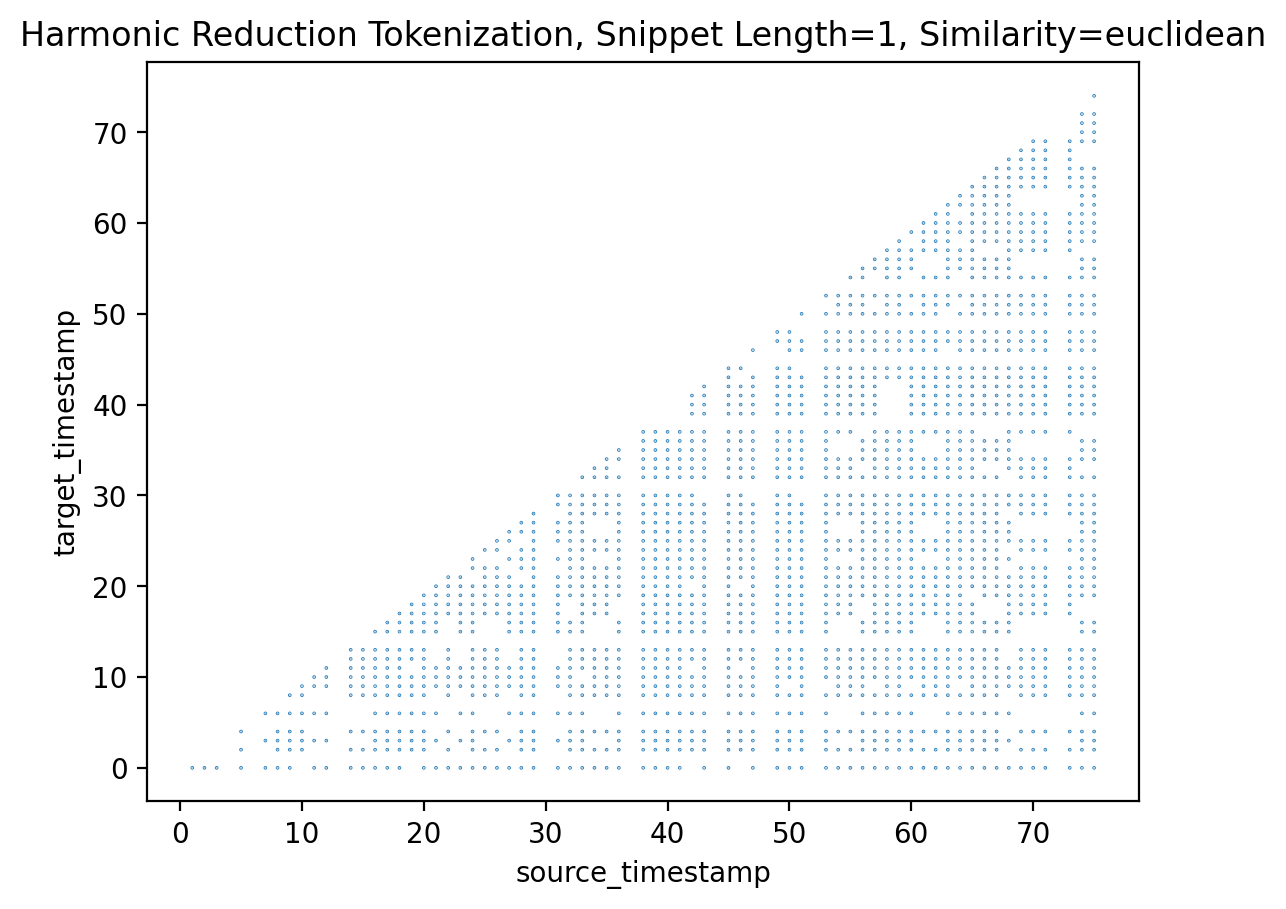

In [184]:
# euclidean distance
similarityMetric = "euclidean"

sims = []
for i in range(len(snippets) - maxNotes):
    # only calculate on historical timestamps
    source = snippets[i+maxNotes]
    targets = snippets[0:i]
    sim = calculate_similarity_1(targets, model, source, similarityMetric)
    # create a single df
    for match in sim:
       
        # add source measure location
        match.insert(0, i)
        sims.append(match)
simsDF = pd.DataFrame(data=sims, columns=['source_timestamp', 'target_timestamp', 'score'])
title = "Harmonic Reduction Tokenization, Snippet Length=" + str(minNotes) + ", Similarity=" + similarityMetric
simsDF.plot.scatter(x="source_timestamp", y="target_timestamp", s='score', title=title)

<AxesSubplot: title={'center': 'Harmonic Reduction Tokenization, Snippet Length=1, Similarity=levenshtein'}, xlabel='source_timestamp', ylabel='target_timestamp'>

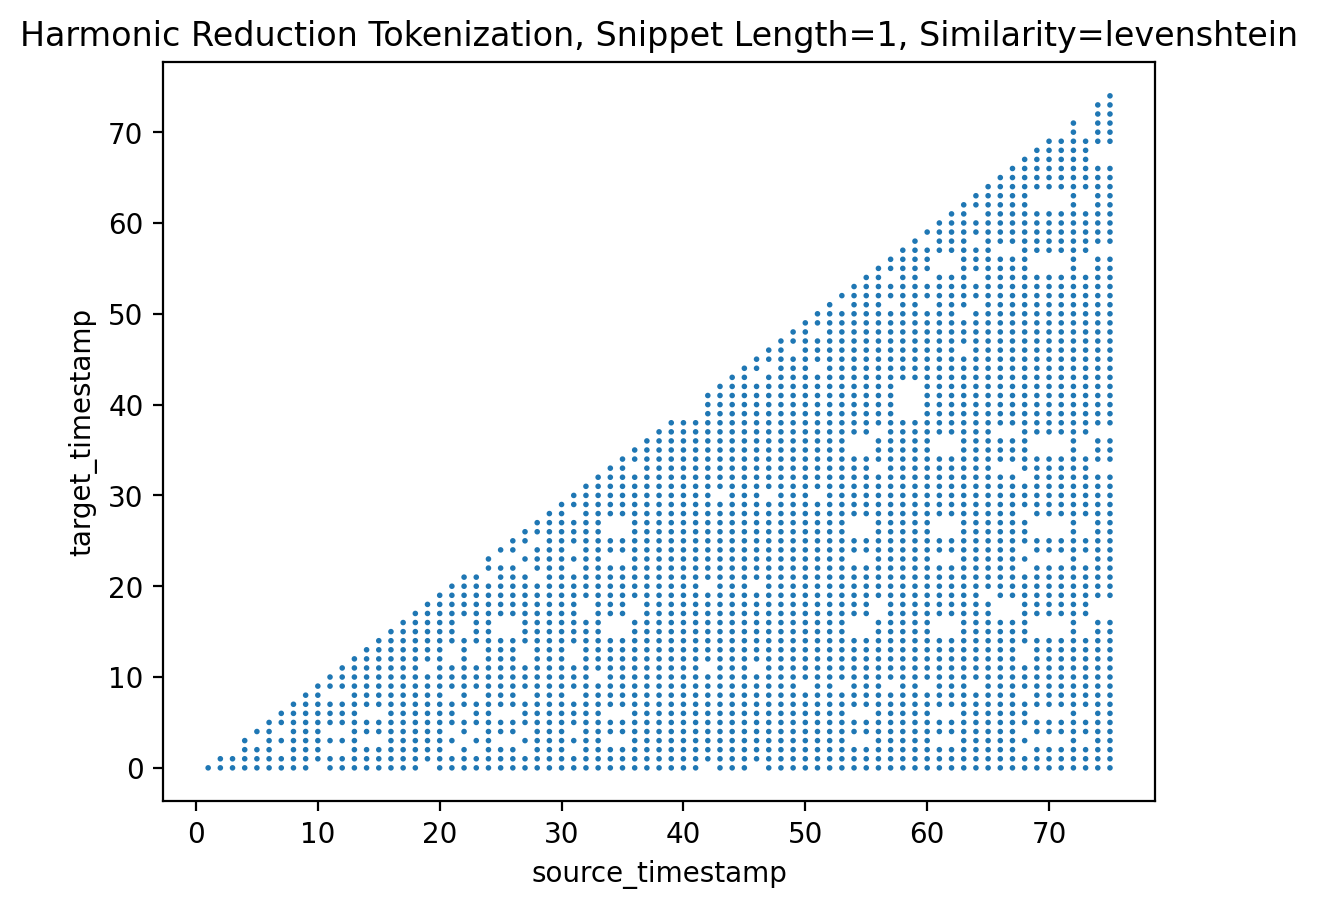

In [185]:
# levenshtein distance
similarityMetric = "levenshtein"

sims = []
for i in range(len(snippets) - maxNotes):
    # only calculate on historical timestamps
    source = snippets[i+maxNotes]
    targets = snippets[0:i]
    sim = calculate_similarity_1(targets, model, source, similarityMetric)
    # create a single df
    for match in sim:
       
        # add source measure location
        match.insert(0, i)
        sims.append(match)
simsDF = pd.DataFrame(data=sims, columns=['source_timestamp', 'target_timestamp', 'score'])
title = "Harmonic Reduction Tokenization, Snippet Length=" + str(minNotes) + ", Similarity=" + similarityMetric
simsDF.plot.scatter(x="source_timestamp", y="target_timestamp", s='score', title=title)

### Approach 2: MIDI Event Tokenization

In [186]:
# Snippet note length = 5
minNotes = 5
maxNotes = 5

<AxesSubplot: title={'center': 'MIDI Event Tokenization, Snippet Length=20, Similarity=cosine'}, xlabel='source_timestamp', ylabel='target_timestamp'>

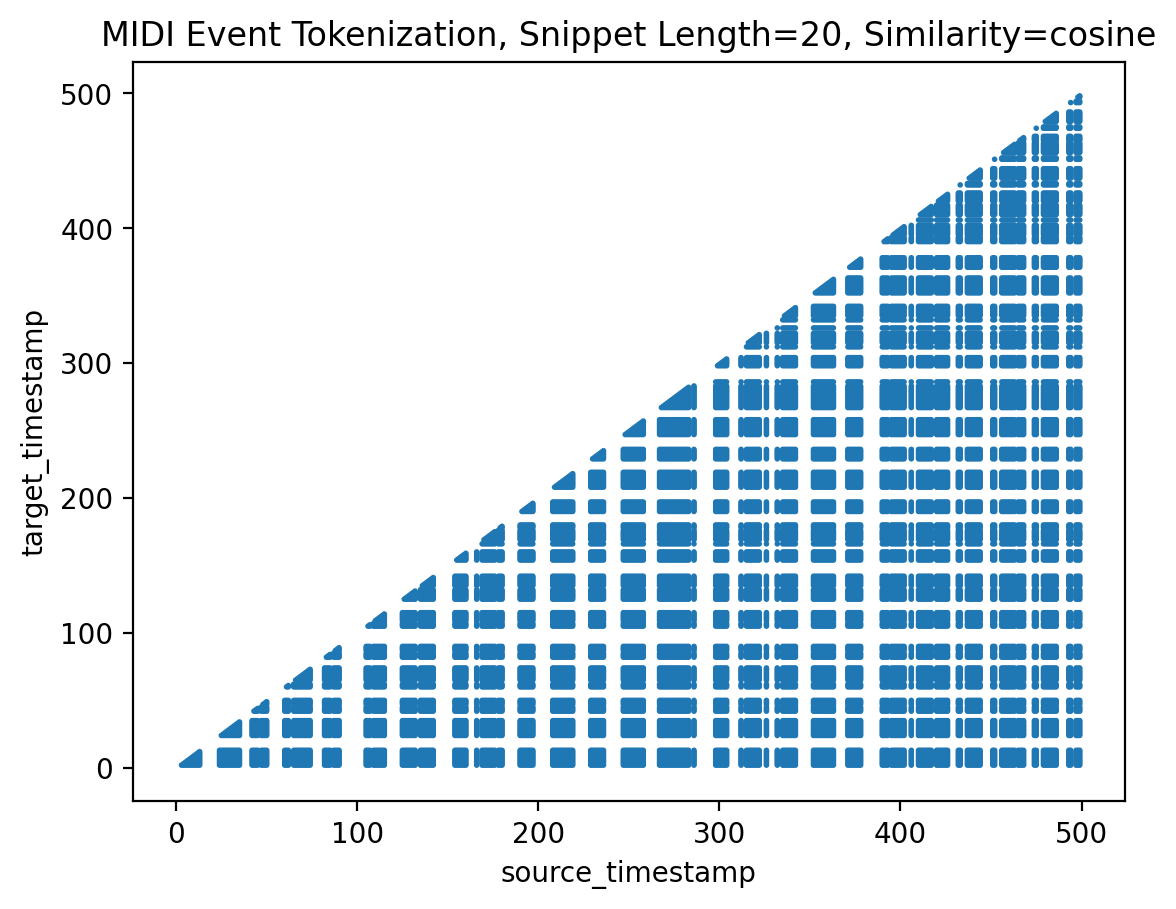

In [198]:
# cosine similarity
similarityMetric = "cosine"

sims = []
for i in range(500):
    # only calculate on historical timestamps
    source = names[i]
    targets = names[0:i]
    sim = calculate_similarity_2(targets, source, similarityMetric)
    # create a single df
    for match in sim:
        # add source measure location
        match.insert(0, i)
        sims.append(match)
simsDF = pd.DataFrame(data=sims, columns=['source_timestamp', 'target_timestamp', 'score'])
title = "MIDI Event Tokenization, Snippet Length=" + str(minNotes) + ", Similarity=" + similarityMetric
simsDF.plot.scatter(x="source_timestamp", y="target_timestamp", s='score', title=title)

<AxesSubplot: title={'center': 'MIDI Event Tokenization, Snippet Length=20, Similarity=euclidean'}, xlabel='source_timestamp', ylabel='target_timestamp'>

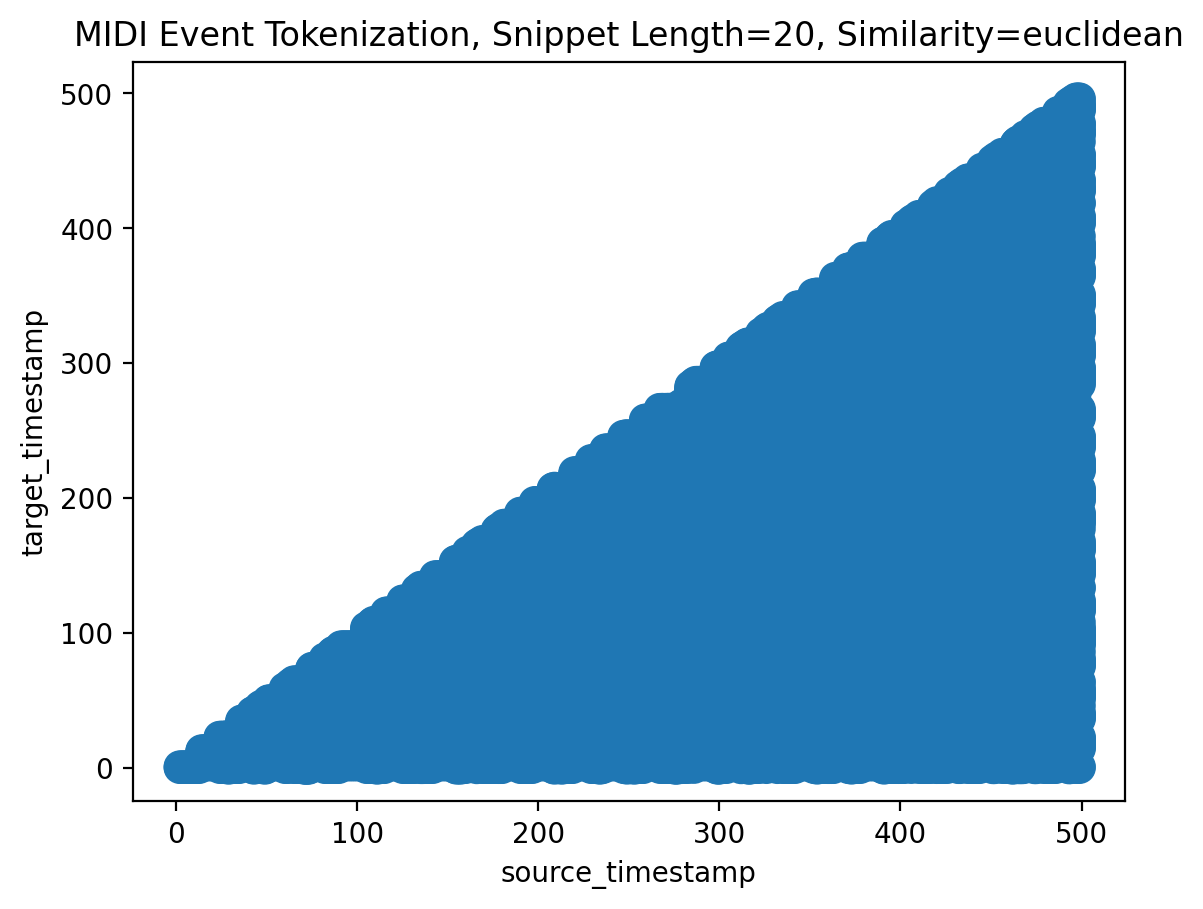

In [199]:
# euclidean similarity
similarityMetric = "euclidean"

sims = []
for i in range(500):
    # only calculate on historical timestamps
    source = names[i]
    targets = names[0:i]
    sim = calculate_similarity_2(targets, source, similarityMetric)
    # create a single df
    for match in sim:
        # add source measure location
        match.insert(0, i)
        sims.append(match)
simsDF = pd.DataFrame(data=sims, columns=['source_timestamp', 'target_timestamp', 'score'])
title = "MIDI Event Tokenization, Snippet Length=" + str(minNotes) + ", Similarity=" + similarityMetric
simsDF.plot.scatter(x="source_timestamp", y="target_timestamp", s='score', title=title)

<AxesSubplot: title={'center': 'MIDI Event Tokenization, Snippet Length=20, Similarity=levenshtein'}, xlabel='source_timestamp', ylabel='target_timestamp'>

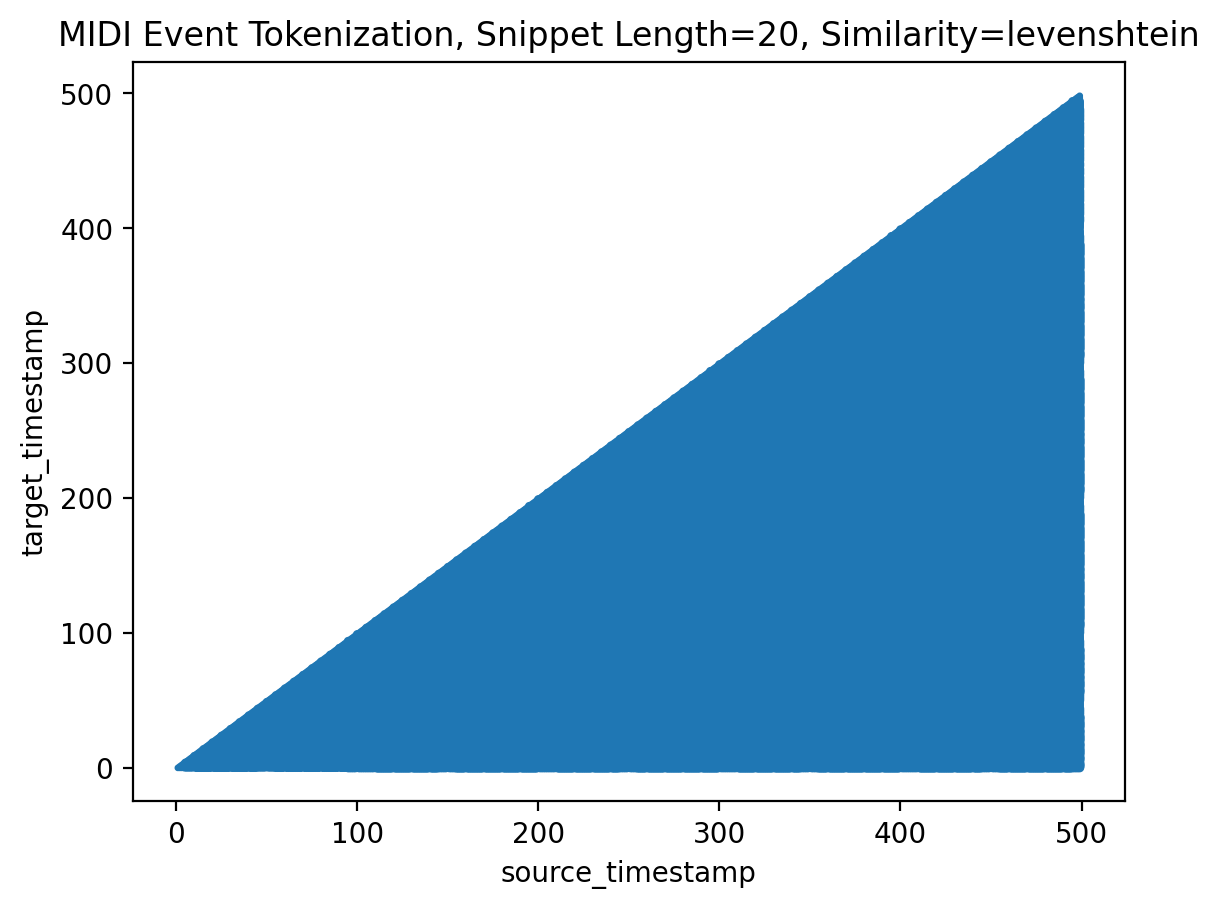

In [200]:
# levenshtein similarity
similarityMetric = "levenshtein"

sims = []
for i in range(500):
    # only calculate on historical timestamps
    source = names[i]
    targets = names[0:i]
    sim = calculate_similarity_2(targets, source, similarityMetric)
    # create a single df
    for match in sim:
        # add source measure location
        match.insert(0, i)
        sims.append(match)
simsDF = pd.DataFrame(data=sims, columns=['source_timestamp', 'target_timestamp', 'score'])
title = "MIDI Event Tokenization, Snippet Length=" + str(minNotes) + ", Similarity=" + similarityMetric
simsDF.plot.scatter(x="source_timestamp", y="target_timestamp", s='score', title=title)

### Approach 3: MIDI Note Vectorization

In [201]:
# Snippet note length = 5
minNotes = 5
maxNotes = 5

<AxesSubplot: title={'center': 'MIDI Note Vectorization, Snippet Length=20, Similarity=cosine'}, xlabel='source_timestamp', ylabel='target_timestamp'>

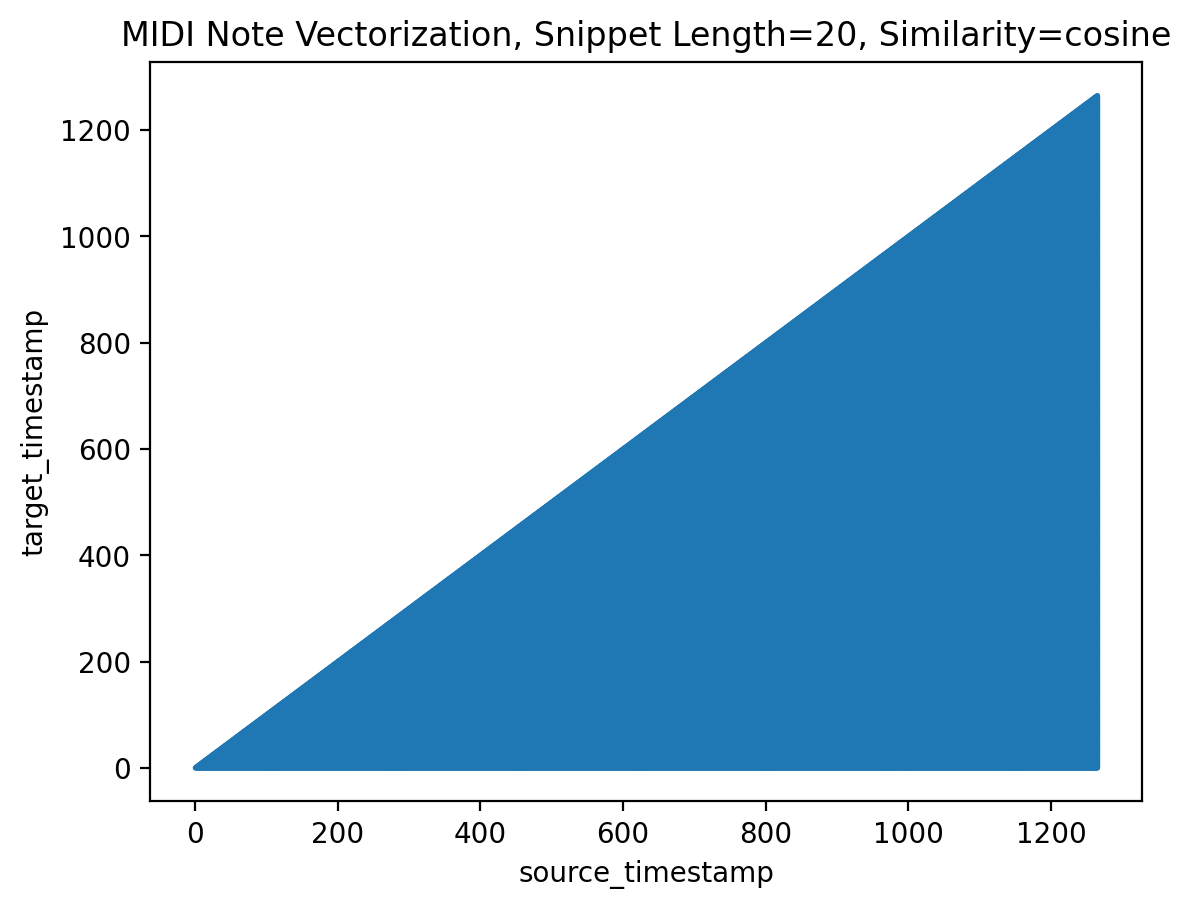

In [202]:
# cosine similarity
similarityMetric = "cosine"
minNotes = 20
maxNotes = 20

sims = []
for i in range(len(snips)):
    # only calculate on historical timestamps
    source = snips[i]
    targets = snips[0:i]
    sim = calculate_similarity_1(targets, noteModel, source, similarityMetric)
    # create a single df
    for match in sim:
        # add source measure location
        match.insert(0, i)
        sims.append(match)
simsDF = pd.DataFrame(data=sims, columns=['source_timestamp', 'target_timestamp', 'score'])
title = "MIDI Note Vectorization, Snippet Length=" + str(minNotes) + ", Similarity=" + similarityMetric
simsDF.plot.scatter(x="source_timestamp", y="target_timestamp", s='score', title=title)

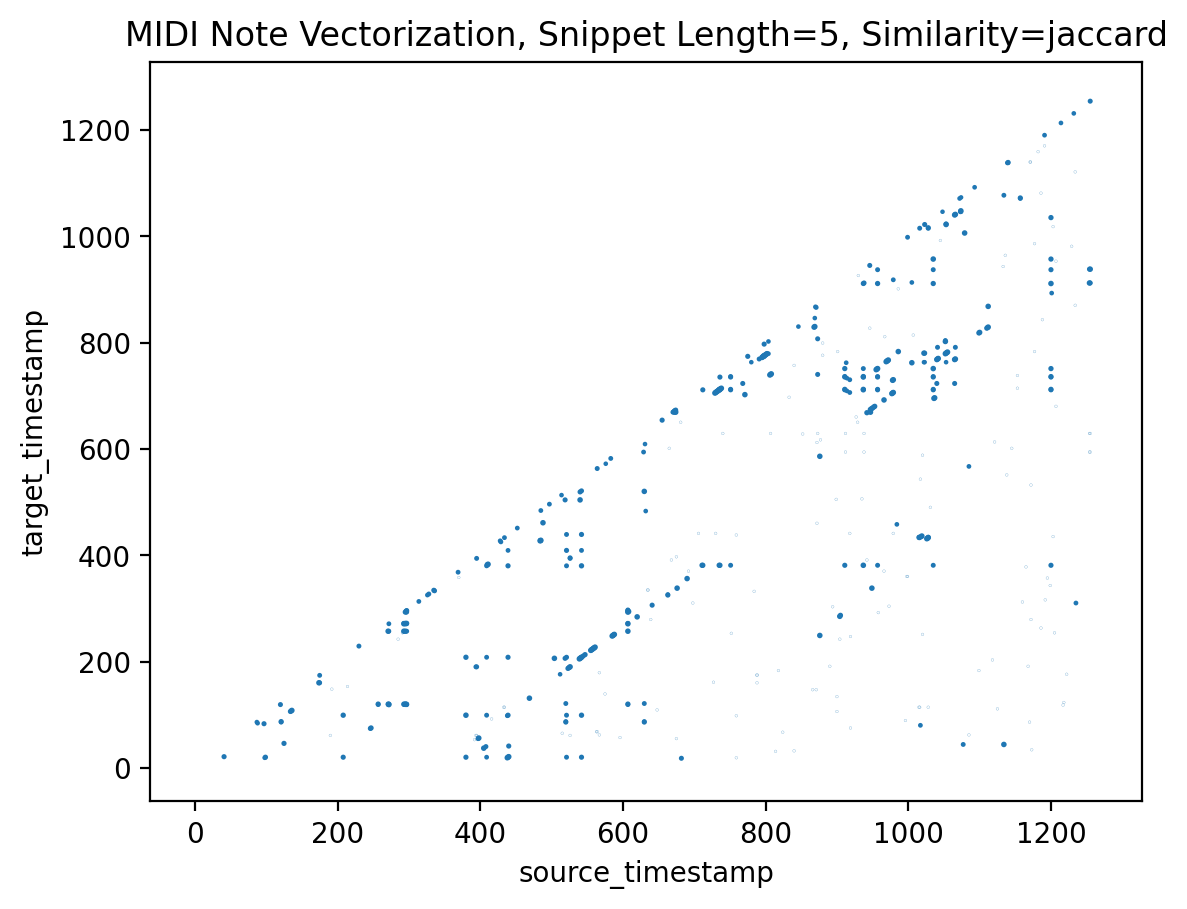

In [203]:
# jaccard similarity
similarityMetric = "jaccard"
minNotes = 5
maxNotes = 5
# generate dataframe of snippets
snips = []
midiFile = converter.parse(midiPath)
notes = extract_notes([midiFile])
for i in range(len(notes)):
    snip = notes[i:i + maxNotes]
    if len(snip) >= minNotes:
        snips.append(snip)
        
noteModel = gensim.models.Word2Vec(snips, min_count=2, window=4)

sims = []
for i in range(len(snips)):
    # only calculate on historical timestamps
    source = snips[i]
    targets = snips[0:i]
    sim = calculate_similarity_1(targets, noteModel, source, similarityMetric)
    # create a single df
    for match in sim:
        # add source measure location
        match.insert(0, i)
        sims.append(match)
simsDF = pd.DataFrame(data=sims, columns=['source_timestamp', 'target_timestamp', 'score'])
title = "MIDI Note Vectorization, Snippet Length=" + str(minNotes) + ", Similarity=" + similarityMetric
simsDF.plot.scatter(x="source_timestamp", y="target_timestamp", s='score', title=title)
plt.savefig("linePlot5.png")

<AxesSubplot: title={'center': 'MIDI Note Vectorization, Snippet Length=20, Similarity=euclidean'}, xlabel='source_timestamp', ylabel='target_timestamp'>

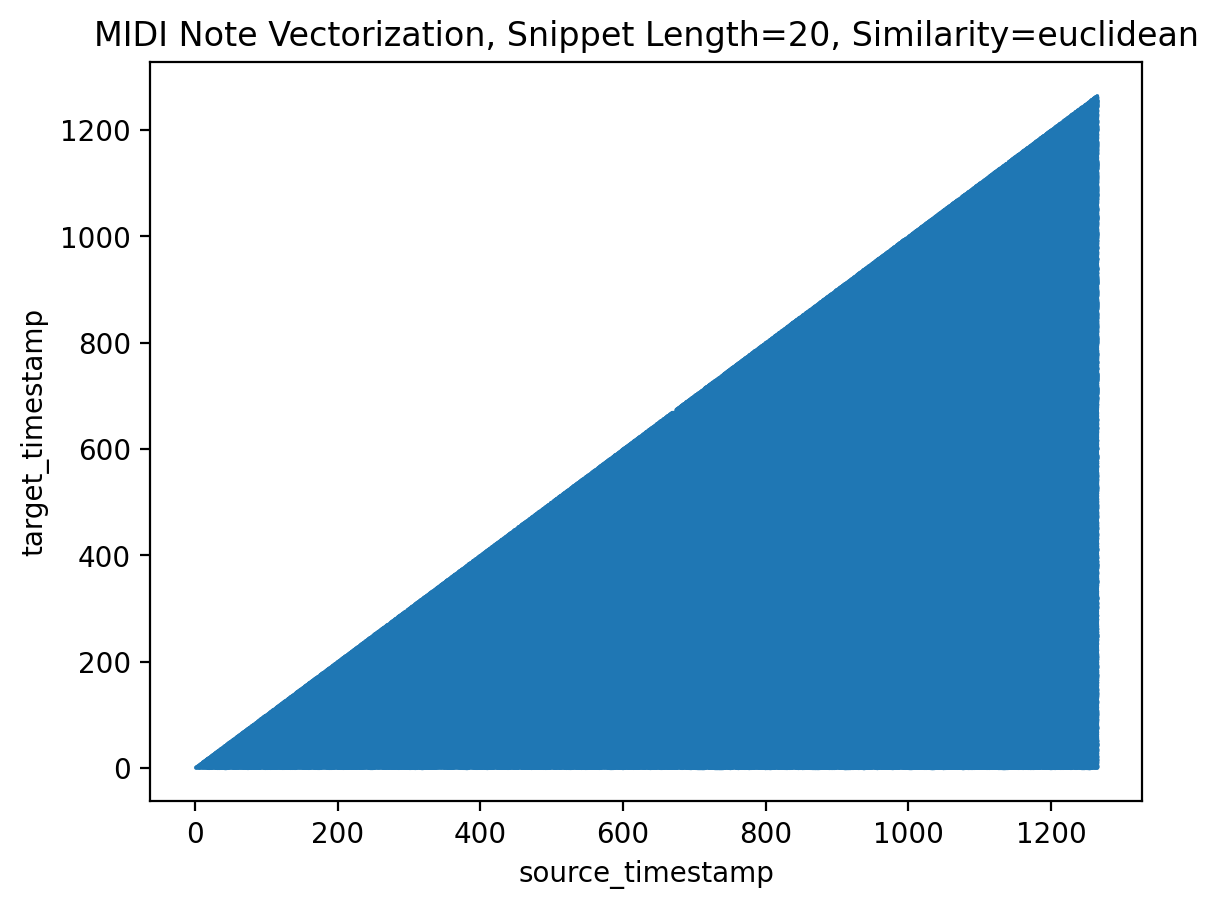

In [204]:
# euclidean similarity
similarityMetric = "euclidean"
minNotes = 20
maxNotes = 20
sims = []
for i in range(len(snips)):
    # only calculate on historical timestamps
    source = snips[i]
    targets = snips[0:i]
    sim = calculate_similarity_1(targets, noteModel, source, similarityMetric)
    # create a single df
    for match in sim:
        # add source measure location
        match.insert(0, i)
        sims.append(match)
simsDF = pd.DataFrame(data=sims, columns=['source_timestamp', 'target_timestamp', 'score'])
title = "MIDI Note Vectorization, Snippet Length=" + str(minNotes) + ", Similarity=" + similarityMetric
simsDF.plot.scatter(x="source_timestamp", y="target_timestamp", s='score', title=title)

<AxesSubplot: title={'center': 'MIDI Note Vectorization, Snippet Length=20, Similarity=levenshtein'}, xlabel='source_timestamp', ylabel='target_timestamp'>

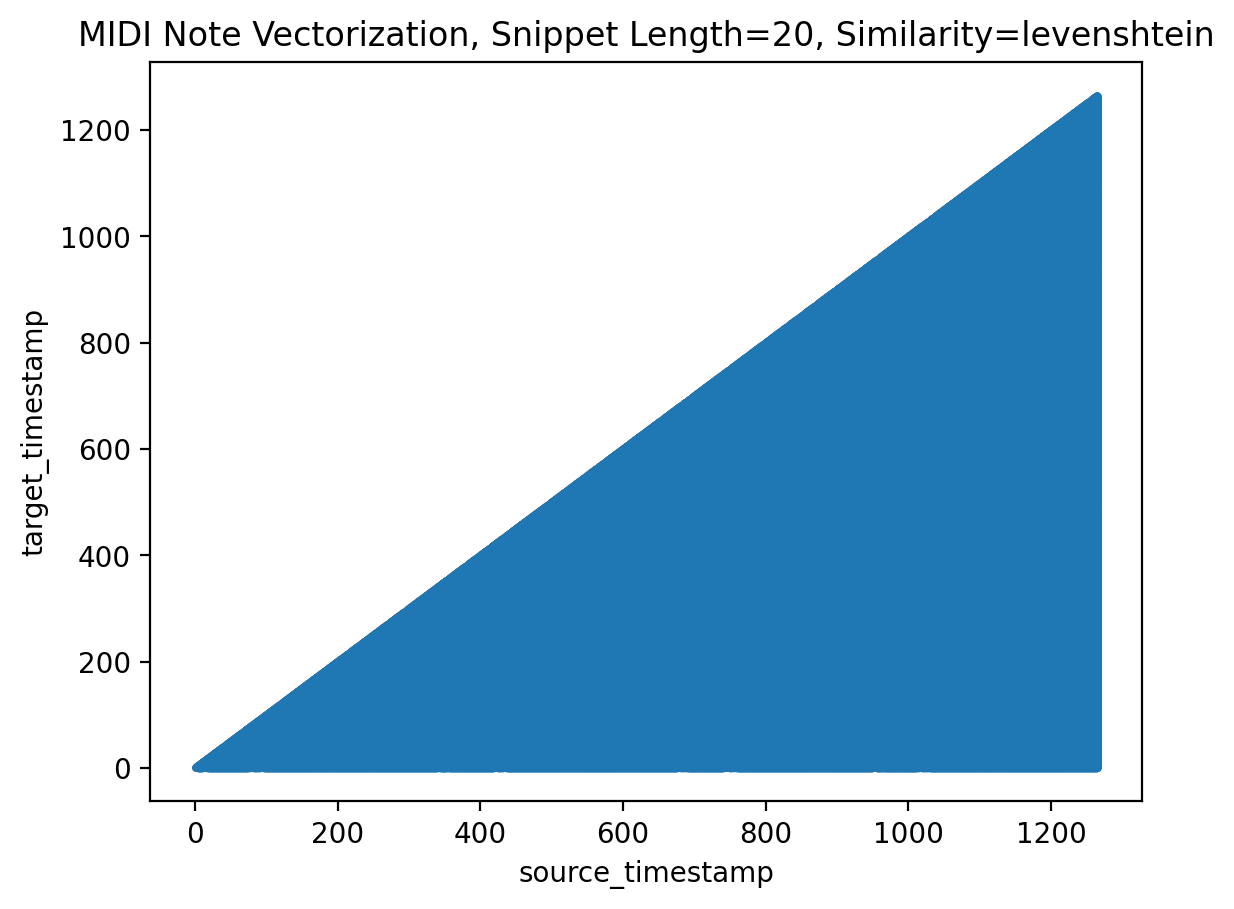

In [205]:
# levenshtein similarity
similarityMetric = "levenshtein"
minNotes = 20
maxNotes = 20
sims = []
for i in range(len(snips)):
    # only calculate on historical timestamps
    source = snips[i]
    targets = snips[0:i]
    sim = calculate_similarity_1(targets, noteModel, source, similarityMetric)
    # create a single df
    for match in sim:
        # add source measure location
        match.insert(0, i)
        sims.append(match)
simsDF = pd.DataFrame(data=sims, columns=['source_timestamp', 'target_timestamp', 'score'])
title = "MIDI Note Vectorization, Snippet Length=" + str(minNotes) + ", Similarity=" + similarityMetric
simsDF.plot.scatter(x="source_timestamp", y="target_timestamp", s='score', title=title)

It seems like the Jaccard Similarity metric on Approach 3 does the best job, so we can try various snippet lengths.

### Additional Experiments

In [ ]:
# Snippet note length = 10
minNotes = 10
maxNotes = 10

In [ ]:
# generate dataframe of snippets
snips = []
midiFile = converter.parse(midiPath)
notes = extract_notes([midiFile])
for i in range(len(notes)):
    snip = notes[i:i + maxNotes]
    if len(snip) >= minNotes:
        snips.append(snip)
        
noteModel = gensim.models.Word2Vec(snips, min_count=2, window=4)

<AxesSubplot: title={'center': 'MIDI Note Vectorization, Snippet Length=10, Similarity=jaccard'}, xlabel='source_timestamp', ylabel='target_timestamp'>

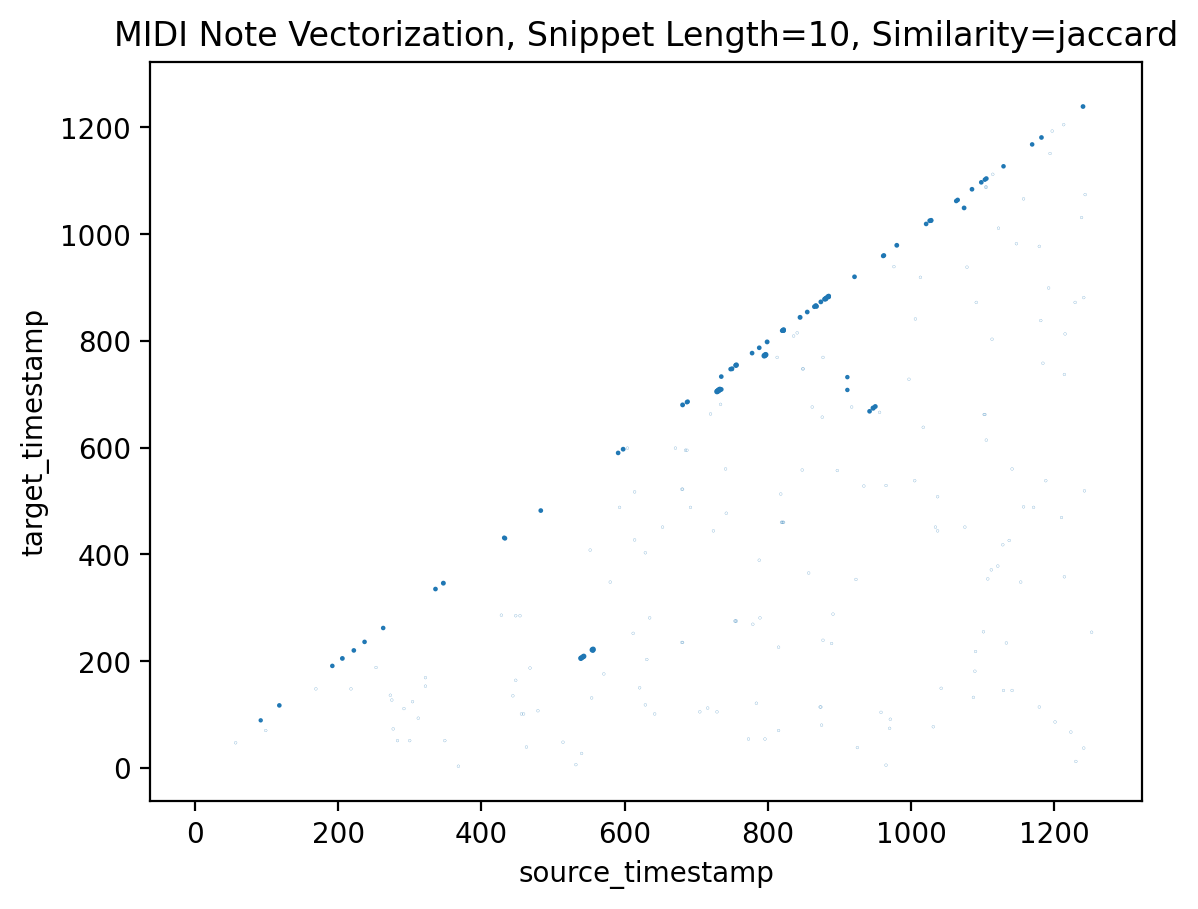

In [120]:
# jaccard similarity
similarityMetric = "jaccard"

sims = []
for i in range(len(snips)):
    # only calculate on historical timestamps
    source = snips[i]
    targets = snips[0:i]
    sim = calculate_similarity_1(targets, noteModel, source, similarityMetric)
    # create a single df
    for match in sim:
        # add source measure location
        match.insert(0, i)
        sims.append(match)
simsDF = pd.DataFrame(data=sims, columns=['source_timestamp', 'target_timestamp', 'score'])
title = "MIDI Note Vectorization, Snippet Length=" + str(minNotes) + ", Similarity=" + similarityMetric
simsDF.plot.scatter(x="source_timestamp", y="target_timestamp", s='score', title=title)

In [121]:
# Snippet note length = 20
minNotes = 20
maxNotes = 20

In [122]:
# generate dataframe of snippets
snips = []
midiFile = converter.parse(midiPath)
notes = extract_notes([midiFile])
for i in range(len(notes)):
    snip = notes[i:i + maxNotes]
    if len(snip) >= minNotes:
        snips.append(snip)
        
noteModel = gensim.models.Word2Vec(snips, min_count=2, window=4)

<AxesSubplot: title={'center': 'MIDI Note Vectorization, Snippet Length=20, Similarity=jaccard'}, xlabel='source_timestamp', ylabel='target_timestamp'>

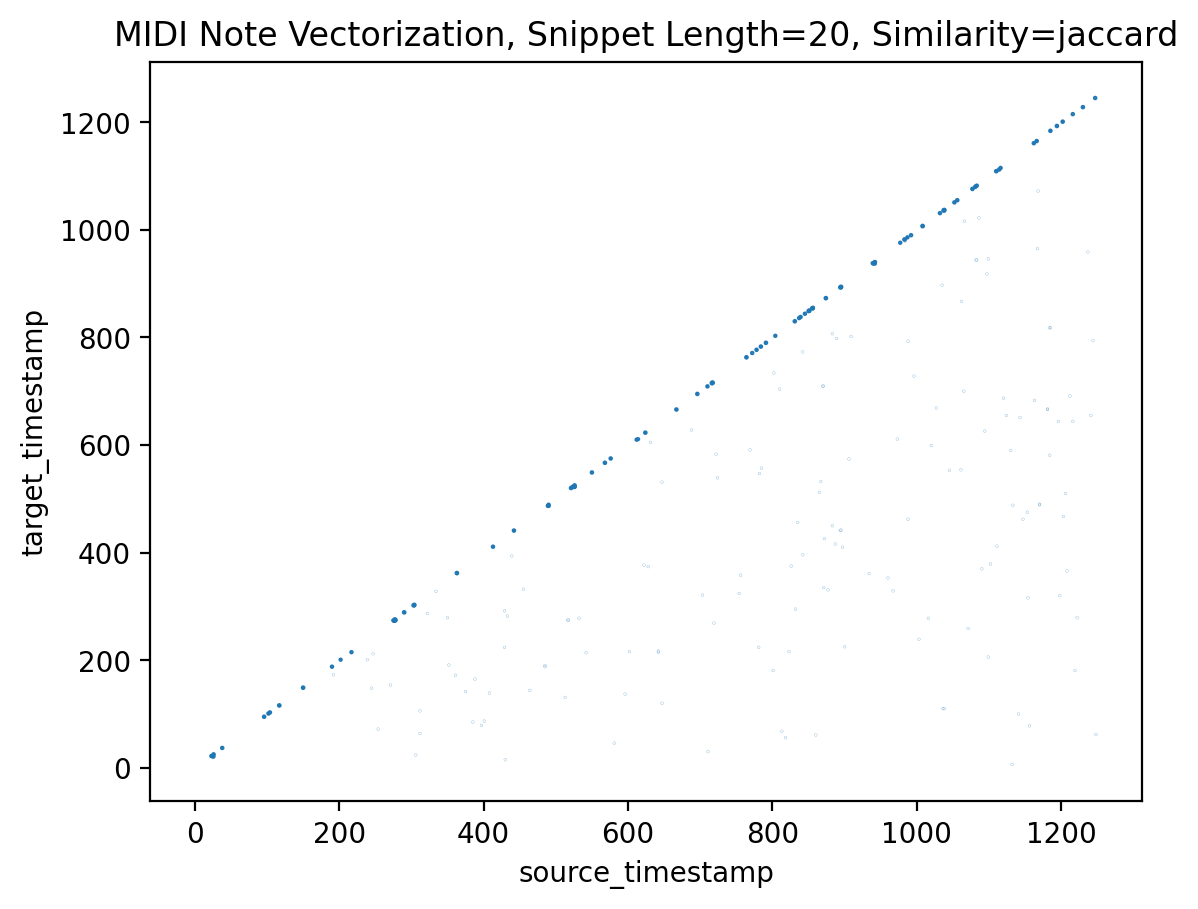

In [123]:
# jaccard similarity
similarityMetric = "jaccard"

sims = []
for i in range(len(snips)):
    # only calculate on historical timestamps
    source = snips[i]
    targets = snips[0:i]
    sim = calculate_similarity_1(targets, noteModel, source, similarityMetric)
    # create a single df
    for match in sim:
        # add source measure location
        match.insert(0, i)
        sims.append(match)
simsDF = pd.DataFrame(data=sims, columns=['source_timestamp', 'target_timestamp', 'score'])
title = "MIDI Note Vectorization, Snippet Length=" + str(minNotes) + ", Similarity=" + similarityMetric
simsDF.plot.scatter(x="source_timestamp", y="target_timestamp", s='score', title=title)

In [124]:
# Snippet note length = 1
minNotes = 1
maxNotes = 1

In [125]:
# generate dataframe of snippets
snips = []
midiFile = converter.parse(midiPath)
notes = extract_notes([midiFile])
for i in range(len(notes)):
    snip = notes[i:i + maxNotes]
    if len(snip) >= minNotes:
        snips.append(snip)
        
noteModel = gensim.models.Word2Vec(snips, min_count=2, window=4)

<AxesSubplot: title={'center': 'MIDI Note Vectorization, Snippet Length=1, Similarity=jaccard'}, xlabel='source_timestamp', ylabel='target_timestamp'>

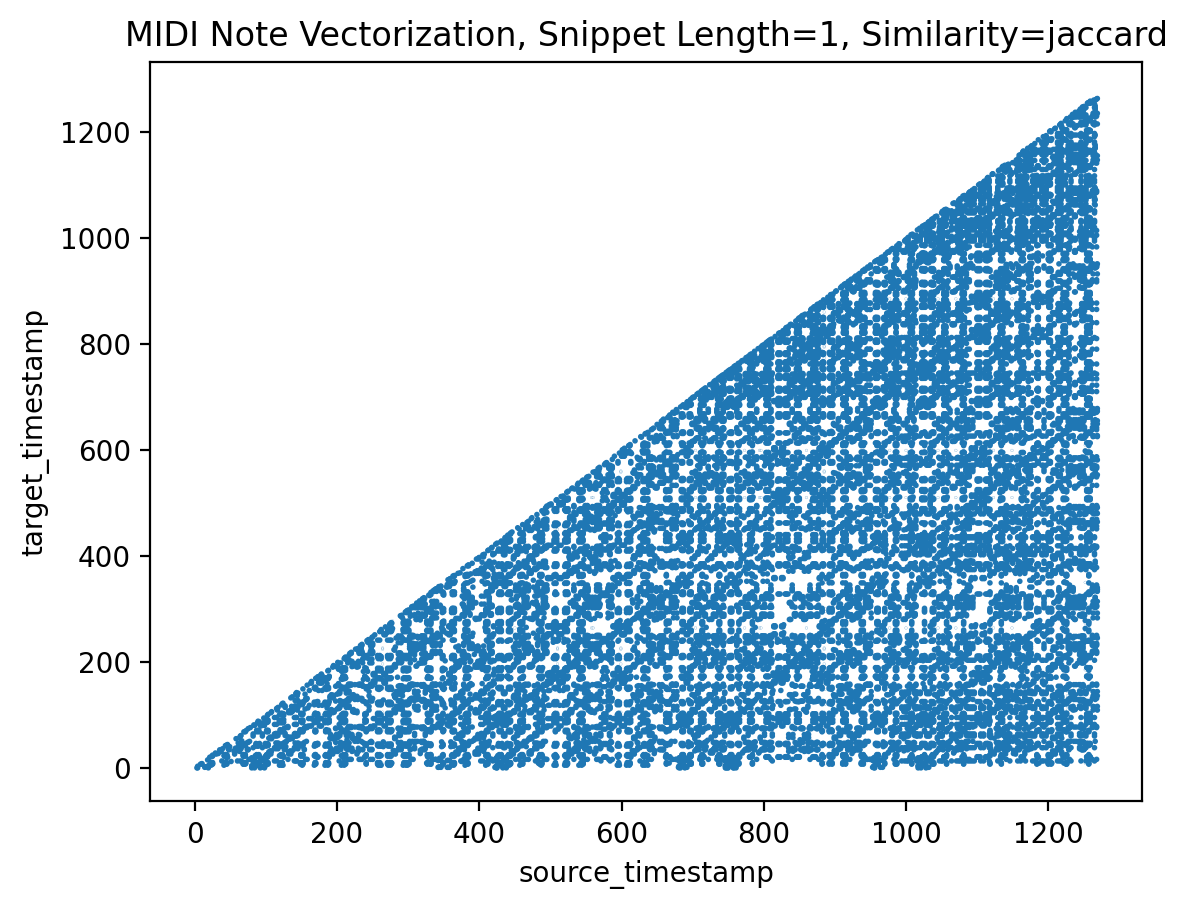

In [126]:
# jaccard similarity
similarityMetric = "jaccard"

sims = []
for i in range(len(snips)):
    # only calculate on historical timestamps
    source = snips[i]
    targets = snips[0:i]
    sim = calculate_similarity_1(targets, noteModel, source, similarityMetric)
    # create a single df
    for match in sim:
        # add source measure location
        match.insert(0, i)
        sims.append(match)
simsDF = pd.DataFrame(data=sims, columns=['source_timestamp', 'target_timestamp', 'score'])
title = "MIDI Note Vectorization, Snippet Length=" + str(minNotes) + ", Similarity=" + similarityMetric
simsDF.plot.scatter(x="source_timestamp", y="target_timestamp", s='score', title=title)

In [147]:
# Snippet note length = 1
minNotes = 6
maxNotes = 6

In [148]:
# generate dataframe of snippets
snips = []
midiFile = converter.parse(midiPath)
notes = extract_notes([midiFile])
for i in range(len(notes)):
    snip = notes[i:i + maxNotes]
    if len(snip) >= minNotes:
        snips.append(snip)
        
noteModel = gensim.models.Word2Vec(snips, min_count=2, window=4)

<AxesSubplot: title={'center': 'MIDI Note Vectorization, Snippet Length=6, Similarity=jaccard'}, xlabel='source_timestamp', ylabel='target_timestamp'>

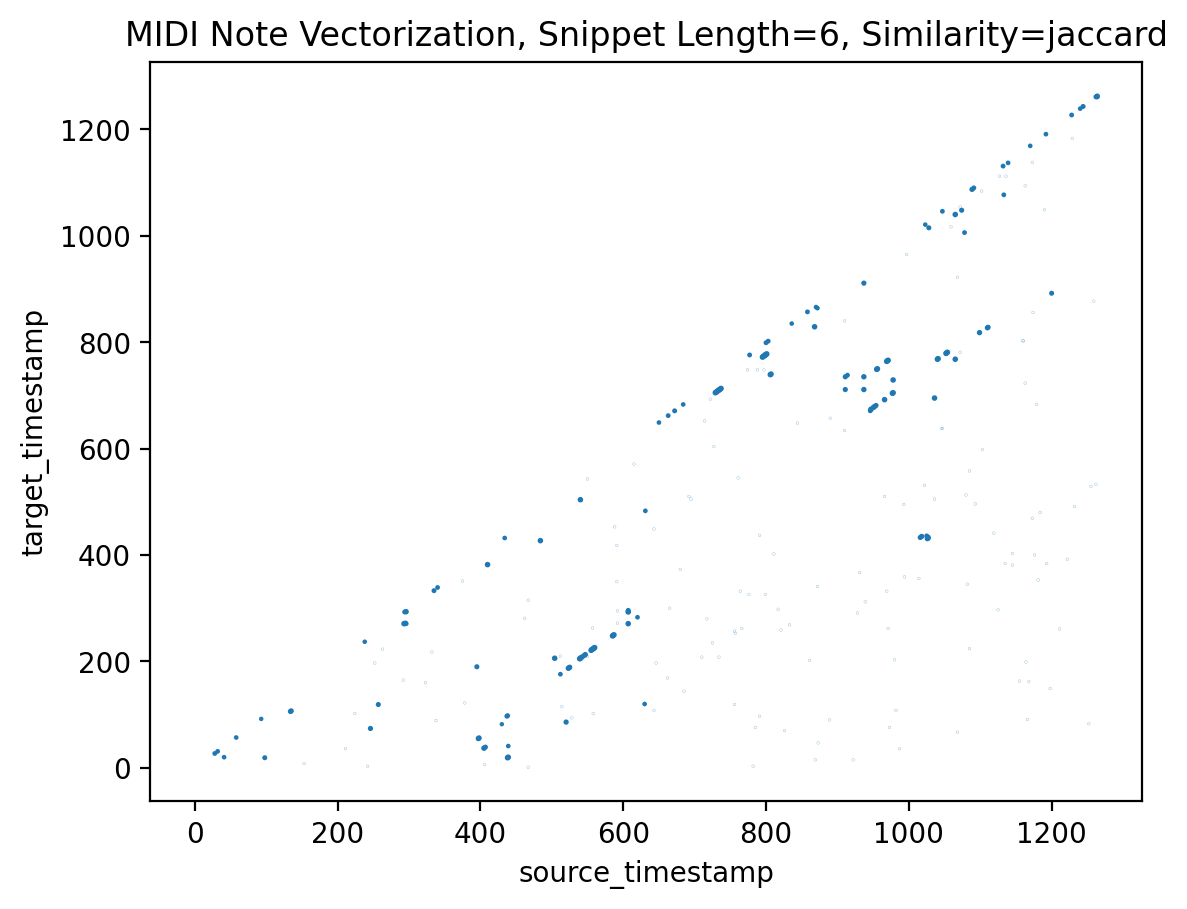

In [149]:
# jaccard similarity
similarityMetric = "jaccard"

sims = []
for i in range(len(snips)):
    # only calculate on historical timestamps
    source = snips[i]
    targets = snips[0:i]
    sim = calculate_similarity_1(targets, noteModel, source, similarityMetric)
    # create a single df
    for match in sim:
        # add source measure location
        match.insert(0, i)
        sims.append(match)
simsDF = pd.DataFrame(data=sims, columns=['source_timestamp', 'target_timestamp', 'score'])
title = "MIDI Note Vectorization, Snippet Length=" + str(minNotes) + ", Similarity=" + similarityMetric
simsDF.plot.scatter(x="source_timestamp", y="target_timestamp", s='score', title=title)

In [151]:
# Snippet note length = 1
minNotes = 4
maxNotes = 4

In [152]:
# generate dataframe of snippets
snips = []
midiFile = converter.parse(midiPath)
notes = extract_notes([midiFile])
for i in range(len(notes)):
    snip = notes[i:i + maxNotes]
    if len(snip) >= minNotes:
        snips.append(snip)
        
noteModel = gensim.models.Word2Vec(snips, min_count=2, window=4)

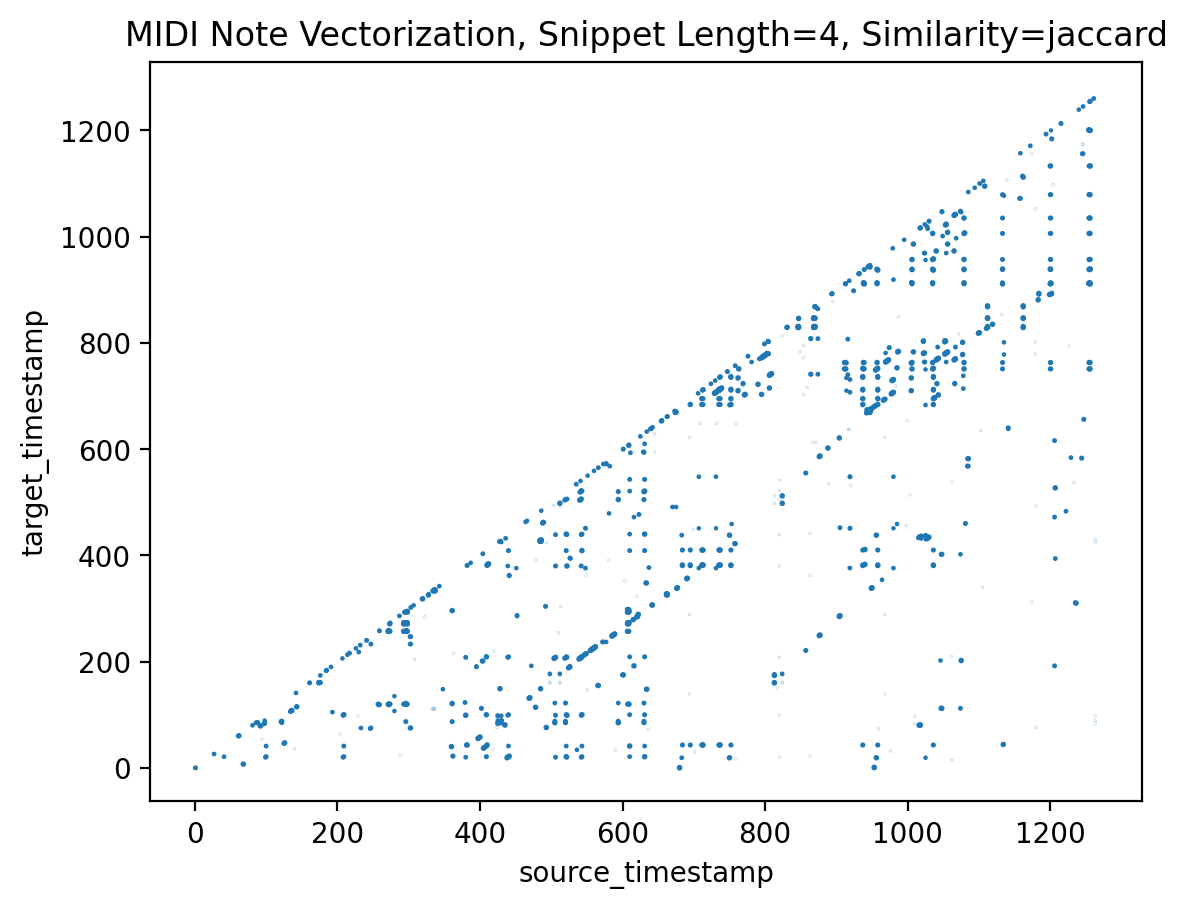

In [153]:
# jaccard similarity
similarityMetric = "jaccard"

sims = []
for i in range(len(snips)):
    # only calculate on historical timestamps
    source = snips[i]
    targets = snips[0:i]
    sim = calculate_similarity_1(targets, noteModel, source, similarityMetric)
    # create a single df
    for match in sim:
        # add source measure location
        match.insert(0, i)
        sims.append(match)
simsDF = pd.DataFrame(data=sims, columns=['source_timestamp', 'target_timestamp', 'score'])
title = "MIDI Note Vectorization, Snippet Length=" + str(minNotes) + ", Similarity=" + similarityMetric
simsDF.plot.scatter(x="source_timestamp", y="target_timestamp", s='score', title=title)
plt.savefig("linePlot.png")

It seems like MIDI Note Vectorization with a snippet length of 4 notes and a similarity metric of Jaccard similarity is the most effective experiment.